In [150]:
# 
import pandas as pd
import numpy as np
import warnings
import pickle
import matplotlib.pyplot as plt
warnings.simplefilter("ignore")

from sklearn import svm
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import GridSearchCV 

In [155]:
col_list=["Reduced_Cost","y_lp","y_int"]#, "Routing_Cost","Capacity","Fixed_Cost"]
df=pd.read_csv("data/data.csv")[col_list]
for col in col_list:
    df[col]=df[col].astype("float")
print(df.shape)
print(df.y_int.value_counts())
df.head(2)

(488, 3)
0.0    287
1.0    201
Name: y_int, dtype: int64


,Reduced_Cost,y_lp,y_int
0,0.0,1.0,1.0
1,0.0,0.0,0.0


In [156]:
train, test = train_test_split(df, test_size=0.3,random_state=42)
# train=df.head(int(0.7*len(df)))
# test=df.tail(int(0.3*len(df)))
print(train.y_int.value_counts())
print(test.y_int.value_counts())
scaler=StandardScaler().fit(train[["Reduced_Cost"]])
# scaler=MinMaxScaler().fit(train[["Reduced_Cost"]])
for col in col_list:
    if col=="y_lp" or col=="y_int":
        continue
    train[col]=scaler.transform(train[[col]])
    test[col]=scaler.transform(test[[col]])

0.0    198
1.0    143
Name: y_int, dtype: int64
0.0    89
1.0    58
Name: y_int, dtype: int64


In [149]:
# test["score"]=pipe.decision_function(test.drop(["y_int"],axis="columns"))
# test["pred"]=pipe.predict(test.drop(["score","y_int"],axis="columns"))
# print(100*len(test[test.y!=test.y_int])/len(test))
# print(test[test.y!=test.y_int][["y_int","y"]].sort_values("y").head(1000))
print(test[["y_lp","y_int","score","pred"]].describe())
test[["y_lp","y_int","score","pred"]].sort_values("score")[test.pred!=test.y_int]

               y_lp       y_int       score        pred
count  1.470000e+02  147.000000  147.000000  147.000000
mean   3.846225e-01    0.394558   -0.332370    0.374150
std    4.527607e-01    0.490426    1.042187    0.485557
min   -3.723200e-11    0.000000   -1.392732    0.000000
25%    0.000000e+00    0.000000   -1.205095    0.000000
50%    6.132250e-02    0.000000   -0.985424    0.000000
75%    1.000000e+00    1.000000    1.001696    1.000000
max    1.000000e+00    1.000000    1.382846    1.000000


,y_lp,y_int,score,pred
316,0.040748,1.0,-1.008213,0.0
195,0.240297,1.0,-0.866092,0.0
63,0.194194,1.0,-0.844818,0.0
104,0.217540,1.0,-0.783866,0.0
419,0.312693,1.0,-0.454024,0.0
68,0.805806,0.0,0.593798,1.0
244,1.000000,0.0,1.308849,1.0


In [128]:
df.corr().y_int

Routing_Cost   -0.035853
Capacity        0.153586
Fixed_Cost     -0.074116
Reduced_Cost   -0.461442
y_lp            0.908750
y_int           1.000000
Name: y_int, dtype: float64

In [176]:
logstic = LogisticRegression()#make_pipeline(StandardScaler(), LogisticRegression())
logstic.fit(train.drop("y_int",axis="columns"), train.y_int) 

print(logstic.score(train.drop("y_int",axis="columns"), train.y_int))
print(logstic.score(test.drop("y_int",axis="columns"), test.y_int))
pickle.dump(logstic, open("logistic.sav", 'wb'))

0.9501466275659824
0.9523809523809523


In [177]:
svm_ = svm.SVC()#make_pipeline(StandardScaler(), svm.SVC())
svm_.fit(train.drop("y_int",axis="columns"), train.y_int) 

print(svm_.score(train.drop("y_int",axis="columns"), train.y_int))
print(svm_.score(test.drop("y_int",axis="columns"), test.y_int))
pickle.dump(svm_, open("svm.sav", 'wb'))

0.9501466275659824
0.9523809523809523


In [174]:
df_=pd.read_csv("ml_output.csv")[["Reduced_Cost","y_lp"]]
print(clf.score(df_, df_.y_lp))

1.0


In [178]:
clf = GradientBoostingClassifier().fit(train.drop("y_int",axis="columns"), train.y_int)
print(clf.score(train.drop("y_int",axis="columns"), train.y_int))
print(clf.score(test.drop("y_int",axis="columns"), test.y_int))
pickle.dump(clf, open("gboost.sav", 'wb'))

0.9941348973607038
0.9319727891156463


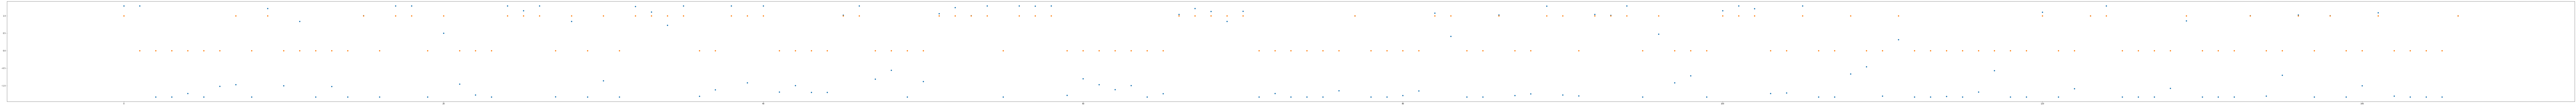

In [98]:
plt.figure(figsize=(250,10))
plt.scatter(range(len(test["y"])),test["y"])
plt.scatter(range(len(test["y"])),test["y_int"])

In [36]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(train.drop("y_int",axis="columns"), train.y_int) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.905, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.976, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=1.000, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.952, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.929, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.881, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.524, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.524, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.524, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.524, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.524, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.524, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.524, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.6s finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)